In [3]:
import os
from openai import OpenAI

In [4]:
deepseek_client = OpenAI(
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    base_url="https://api.deepseek.com"
)

In [5]:
def test_prompt_deepseek(prompt, suppress=False, model='deepseek-chat', **kwargs):
    " a simple function to take in a prompt and run it through a given non-chat model "
        
    chat_completion = deepseek_client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model=model,
        **kwargs
    )
    answer = chat_completion.choices[0].message.content
    if not suppress:
        print(f'PROMPT:\n------\n{prompt}\n------\nRESPONSE (from {model})\n------\n{answer}')
    else:
        return answer


In [6]:
test_prompt_deepseek('1+1=')

PROMPT:
------
1+1=
------
RESPONSE (from deepseek-chat)
------
**Solution:**

To solve the equation \(1 + 1\), follow these simple steps:

1. **Identify the numbers to add:**
   \[
   1 \quad \text{and} \quad 1
   \]

2. **Perform the addition:**
   \[
   1 + 1 = 2
   \]

3. **Final Answer:**
   \[
   \boxed{2}
   \]


# Dynamic k shot using embeddings WITH MathQA

In [7]:
def is_num(x):
    try:
        return float(x) != None
    except:
        return False
is_num(1), is_num('true')

(True, False)

In [8]:
from datasets import load_dataset

dataset = load_dataset("math_qa")
dataset

/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Generating train split:   0%|          | 0/29837 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2985 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4475 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category'],
        num_rows: 29837
    })
    test: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category'],
        num_rows: 2985
    })
    validation: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category'],
        num_rows: 4475
    })
})

In [9]:
print(dataset['train']['Problem'][0])


the banker ' s gain of a certain sum due 3 years hence at 10 % per annum is rs . 36 . what is the present worth ?


In [10]:
dataset = dataset.map(
    lambda x: {
        'question': x['Problem'], 
        'response': x['Rationale'].split('answer ')[0], 
        'answer': x['options'].split(f'{x["correct"]} ) ')[-1].split(' ')[0]
    }
)
dataset = dataset.filter(lambda x: is_num(x['answer']))
dataset

Map:   0%|          | 0/29837 [00:00<?, ? examples/s]

Map:   0%|          | 0/2985 [00:00<?, ? examples/s]

Map:   0%|          | 0/4475 [00:00<?, ? examples/s]

Filter:   0%|          | 0/29837 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2985 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4475 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category', 'question', 'response', 'answer'],
        num_rows: 26318
    })
    test: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category', 'question', 'response', 'answer'],
        num_rows: 2667
    })
    validation: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category', 'question', 'response', 'answer'],
        num_rows: 3983
    })
})

In [11]:
dataset['test'][0]

{'Problem': 'a shopkeeper sold an article offering a discount of 5 % and earned a profit of 31.1 % . what would have been the percentage of profit earned if no discount had been offered ?',
 'Rationale': '"giving no discount to customer implies selling the product on printed price . suppose the cost price of the article is 100 . then printed price = 100 ã — ( 100 + 31.1 ) / ( 100 â ˆ ’ 5 ) = 138 hence , required % profit = 138 â € “ 100 = 38 % answer a"',
 'options': 'a ) 38 , b ) 27.675 , c ) 30 , d ) data inadequate , e ) none of these',
 'correct': 'a',
 'annotated_formula': 'subtract(divide(multiply(add(const_100, 31.1), const_100), subtract(const_100, 5)), const_100)',
 'linear_formula': 'add(n1,const_100)|subtract(const_100,n0)|multiply(#0,const_100)|divide(#2,#1)|subtract(#3,const_100)|',
 'category': 'gain',
 'question': 'a shopkeeper sold an article offering a discount of 5 % and earned a profit of 31.1 % . what would have been the percentage of profit earned if no discount ha

In [12]:
print(dataset['train']['question'][0])
print()
print(dataset['train']['response'][0])
print()
print(dataset['train']['answer'][0])

average age of students of an adult school is 40 years . 120 new students whose average age is 32 years joined the school . as a result the average age is decreased by 4 years . find the number of students of the school after joining of the new students .

"explanation : let the original no . of students be x . according to situation , 40 x + 120 * 32 = ( x + 120 ) 36 ⇒ x = 120 so , required no . of students after joining the new students = x + 120 = 240 . 

240


In [145]:
dataset = dataset.filter(lambda x: float(x['answer']) > 10000)

Filter:   0%|          | 0/690 [00:00<?, ? examples/s]

Filter:   0%|          | 0/78 [00:00<?, ? examples/s]

Filter:   0%|          | 0/85 [00:00<?, ? examples/s]

In [14]:
def format_k_shot(examples, cot=True):
    if cot:
        return '\n###\n'.join(
            [f'Question: {e["question"]}\nReasoning: {e["response"]}\nAnswer: {e["answer"]}' for e in examples]
        )
    else:
        return '\n###\n'.join(
            [f'Question: {e["question"]}\nAnswer: {e["answer"]}' for e in examples]
        )

In [15]:
unanswered_example = dataset['test'][0]

PROMPT = f"""Answer the question in the following format:

{format_k_shot(list(dataset['train'])[:3])}
###
Question: {unanswered_example["question"]}
Reasoning:""".strip()

print(PROMPT)

Answer the question in the following format:

Question: if the annual increase in the population of a town is 10 % and the present number of people is 10000 , what will the population be in 2 years ?
Reasoning: "the required population is = 10000 ( 1 + 10 / 100 ) ^ 2 = 10000 * 11 / 10 * 11 / 10 = 12100 
Answer: 12100
###
Question: a , b and c started a partnership business by investing rs . 12000 , rs . 16000 , rs . 20000 respectively . at the end of the year , the profit were distributed among them . if c ' s share of profit is 36000 , what is the total profit ?
Reasoning: "a : b : c = 12000 : 16000 : 20000 = 3 : 4 : 5 let total profit = p then p ã — 5 / 12 = 36000 p = ( 36000 ã — 12 ) / 5 = 86400 
Answer: 86400
###
Question: sonika deposited rs . 8000 which amounted to rs . 11200 after 3 years at simple interest . had the interest been 2 % more . she would get how much ?
Reasoning: "( 8000 * 3 * 2 ) / 100 = 480 11200 - - - - - - - - 11680 
Answer: 11680
###
Question: in an election b

In [27]:
print(PROMPT)

Answer the question in the following format:

Question: if the annual increase in the population of a town is 10 % and the present number of people is 10000 , what will the population be in 2 years ?
Reasoning: "the required population is = 10000 ( 1 + 10 / 100 ) ^ 2 = 10000 * 11 / 10 * 11 / 10 = 12100 
Answer: 12100
###
Question: a , b and c started a partnership business by investing rs . 12000 , rs . 16000 , rs . 20000 respectively . at the end of the year , the profit were distributed among them . if c ' s share of profit is 36000 , what is the total profit ?
Reasoning: "a : b : c = 12000 : 16000 : 20000 = 3 : 4 : 5 let total profit = p then p ã — 5 / 12 = 36000 p = ( 36000 ã — 12 ) / 5 = 86400 
Answer: 86400
###
Question: sonika deposited rs . 8000 which amounted to rs . 11200 after 3 years at simple interest . had the interest been 2 % more . she would get how much ?
Reasoning: "( 8000 * 3 * 2 ) / 100 = 480 11200 - - - - - - - - 11680 
Answer: 11680
###
Question: in an election b

In [107]:
test_prompt_deepseek('what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )', model='deepseek-chat')

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [22]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

docs = dataset['train']['question']
doc_emb = model.encode(docs, batch_size=32, show_progress_bar=True)

doc_emb.shape  #  == (n, 768)


/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

(690, 768)

In [23]:
from random import sample
from sentence_transformers import util

query = dataset['test']['question'][0]
print(query)


in an election between two candidates , the winner has a margin of 10 % of the votes polled . if 4000 people change their mind and vote for the loser , the loser would have won by a margin of 10 % of the votes polled . find the total number of votes polled in the election ?


In [24]:
import re
import numpy as np
import random

def extract_num(string):
    pattern = r'[\d,]+'
    match = re.search(pattern, string)
    if match:
        number_str = match.group()
        try:
            number = float(number_str.replace(',', ''))
            return number
        except:
            return -1
    return -1
     
def test_k_shot(
    k, datapoint, verbose=False, how='closest', cot=True, options=MODELS
):
    results = {}
    query_emb = model.encode(datapoint['question'])
    prompt_elements = ['Answer the question in the following format:']
    if cot:
        prompt_elements.append('Question: (a question)\nReasoning: (thinking through step by step on how to solve the problem)\nAnswer: (the final answer as a number)')
    else:
        prompt_elements.append('Question: (a question)\nAnswer: (the final answer as a number)')
    
    if k > 0:
        if how == 'closest':
            scores = util.dot_score(query_emb, doc_emb)[0].cpu().tolist()
            # Retrieve the corresponding examples from the dataset
            examples = [dataset['train'][int(_)] for _ in np.argsort(scores)[-k:][::-1]]
        else:
            examples = random.sample(list(dataset['train']), k)
        
        prompt_elements.append(format_k_shot(examples, cot=cot))
    
    if cot:
        prompt_elements.append(f'Question: {datapoint["question"]}\nReasoning:')
    else:
        prompt_elements.append(f'Question: {datapoint["question"]}\nAnswer:')
        
    
    PROMPT = '\n\n'.join(prompt_elements)
    
    if verbose:
        print(f'PROMPT\n-----\n{PROMPT}\n-----')

    
    if 'deepseek-chat' in options:
        response = test_prompt_deepseek(PROMPT, model='deepseek-chat', temperature=0, suppress=True)
        results['deepseek-chat'] = {'num': extract_num(response.split('Answer: ')[-1]), 'response': response}
    
    results['answer'] = extract_num(datapoint['answer'])
    
    return results

In [25]:
MODELS = ['deepseek-chat']


In [65]:
datapoint = dataset['test'][1]
test_k_shot(0, datapoint, verbose=True, cot=False)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Answer: (the final answer as a number)

Question: what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )
Answer:
-----


{'deepseek-chat': {'num': 11988.0,
  'response': 'Question: What is the sum of all 3-digit integers formed using the digits 3, 4, and 5 (repetition is allowed)?\n\nAnswer: 11988\n\n---\n\n### Explanation:\nThere are \\(3 \\times 3 \\times 3 = 27\\) possible 3-digit numbers formed using the digits 3, 4, and 5 (with repetition allowed). Each digit (3, 4, 5) appears equally often in each place (hundreds, tens, and units). \n\n- Each digit appears \\(27 / 3 = 9\\) times in each place.\n- The sum of the digits is \\(3 + 4 + 5 = 12\\).\n- The contribution of each place to the total sum is \\(9 \\times 12 = 108\\).\n- The total sum is \\(108 \\times 100 + 108 \\times 10 + 108 \\times 1 = 10800 + 1080 + 108 = 11988\\).\n\nThus, the final answer is **11988**.'},
 'answer': 11988.0}

In [66]:
test_k_shot(0, datapoint, verbose=True, cot=True)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Reasoning: (thinking through step by step on how to solve the problem)
Answer: (the final answer as a number)

Question: what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )
Reasoning:
-----


{'deepseek-chat': {'num': 11988.0,
  'response': 'Question: What is the sum of all 3-digit integers formed using the digits 3, 4, and 5 (repetition is allowed)?\n\nReasoning:\n1. **Identify the digits and their possible positions**: The digits available are 3, 4, and 5. Each digit can appear in the hundreds, tens, or units place, and repetition is allowed. This means there are \\(3 \\times 3 \\times 3 = 27\\) possible 3-digit numbers.\n\n2. **Calculate the contribution of each digit to the total sum**:\n   - **Hundreds place**: Each digit (3, 4, 5) will appear in the hundreds place \\(3 \\times 3 = 9\\) times (since the tens and units places can be any of the 3 digits). The total contribution from the hundreds place is:\n     \\[\n     (3 + 4 + 5) \\times 9 \\times 100 = 12 \\times 9 \\times 100 = 10,800\n     \\]\n   - **Tens place**: Similarly, each digit will appear in the tens place 9 times. The total contribution from the tens place is:\n     \\[\n     (3 + 4 + 5) \\times 9 \\time

In [67]:
test_k_shot(1, datapoint, verbose=True, how='random', cot=True)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Reasoning: (thinking through step by step on how to solve the problem)
Answer: (the final answer as a number)

Question: the difference between the place values of two sevens in the numerical 69758472 is
Reasoning: "required difference = ( 700000 - 70 ) = 699930 . 
Answer: 699930

Question: what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )
Reasoning:
-----


{'deepseek-chat': {'num': 11988.0,
  'response': 'Question: What is the sum of all 3-digit integers formed using the digits 3, 4, and 5 (repetition is allowed)?\n\nReasoning:  \n1. The digits available are 3, 4, and 5, and repetition is allowed.  \n2. Each 3-digit number will have a hundreds place, a tens place, and a units place.  \n3. Each digit (3, 4, 5) will appear equally often in each place (hundreds, tens, units).  \n4. Since there are 3 digits and 3 places, each digit will appear \\( 3 \\times 3 = 9 \\) times in each place.  \n5. The sum of the digits is \\( 3 + 4 + 5 = 12 \\).  \n6. The contribution of each place to the total sum is \\( 12 \\times 9 = 108 \\).  \n7. The total sum is the sum of the contributions from all three places:  \n   - Hundreds place: \\( 108 \\times 100 = 10800 \\)  \n   - Tens place: \\( 108 \\times 10 = 1080 \\)  \n   - Units place: \\( 108 \\times 1 = 108 \\)  \n8. Adding these together: \\( 10800 + 1080 + 108 = 11988 \\).  \n\nAnswer: 11988'},
 'ans

In [68]:
test_k_shot(1, datapoint, verbose=True, how='closest', cot=True)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Reasoning: (thinking through step by step on how to solve the problem)
Answer: (the final answer as a number)

Question: what is the sum of all 4 digit integers formed using the digits 2 , 3 , 4 and 5 ( repetition is allowed )
Reasoning: n = 4 * 4 * 4 * 4 = 256 < x > = ( 5555 + 2222 ) / 2 = 3888.5 sum = number of integers x average value n * < x > = 256 * 3888.5 = 711040 
Answer: 995456

Question: what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )
Reasoning:
-----


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [125]:
test_k_shot(3, datapoint, verbose=True, how='closest', cot=True)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Reasoning: (thinking through step by step on how to solve the problem)
Answer: (the final answer as a number)

Question: what is the sum of all 4 digit integers formed using the digits 2 , 3 , 4 and 5 ( repetition is allowed )
Reasoning: n = 4 * 4 * 4 * 4 = 256 < x > = ( 5555 + 2222 ) / 2 = 3888.5 sum = number of integers x average value n * < x > = 256 * 3888.5 = 711040 
Answer: 995456
###
Question: find the sum of all 4 digit numbers formed using digits 1,2 , 5,6 .
Reasoning: "( n - 1 ) ! * ( 111 . . . n ) * ( sum of the digits ) = ( 4 - 1 ) ! * 1111 * ( 1 + 2 + 5 + 6 ) = 93324 
Answer: 93324
###
Question: what is the sum of all 3 digit nos formed by { 1 , 3,5 , 7,9 } with nos not repeated
Reasoning: "here 3 digit no . can be formed in 5 * 4 * 3 = 60 . thus we hv to find the sum of 60 nos . now 60 / 5 = 12 ; we hv 12 no ' s . starting with 1 , 12 no ' s . with 3,5 , 7,9 . . . . so 12 * 100 * ( 1 + 3 + 5

{'deepseek-chat': {'num': 11988.0,
  'response': 'Question: what is the sum of all 3 digit integers formed using the digits 3, 4, and 5 (repetition is allowed)\nReasoning: To find the sum of all 3-digit integers formed using the digits 3, 4, and 5 with repetition allowed, we can use the following approach:\n\n1. **Total number of 3-digit numbers**: Since repetition is allowed, each digit (hundreds, tens, and units) can be 3, 4, or 5. Thus, the total number of 3-digit numbers is \\(3 \\times 3 \\times 3 = 27\\).\n\n2. **Average value of the numbers**: The average value of all possible 3-digit numbers formed by these digits can be calculated by taking the average of the smallest and largest numbers. The smallest number is 333, and the largest number is 555. The average is \\(\\frac{333 + 555}{2} = 444\\).\n\n3. **Sum of all numbers**: The sum of all numbers is the total number of numbers multiplied by the average value. Thus, the sum is \\(27 \\times 444 = 11988\\).\n\nAnswer: 11988'},
 

In [146]:
t, batch_size = 5, 1  # time to wait in seconds, batch size

In [126]:
import numpy as np
import random

random.seed(42)

dataset_sample = random.sample(list(dataset['test']), 50)

In [127]:
len(dataset_sample)

50

In [128]:
dataset_sample[0]

{'Problem': 'the population of a bacteria colony doubles every day . if it was started 8 days ago with 3 bacteria and each bacteria lives for 12 days , how large is the colony today ?',
 'Rationale': '"3 ^ 8 * ( 2 ) = 13122 the answer is c"',
 'options': 'a ) 512 , b ) 768 , c ) 13122 , d ) 2048 , e ) 4096',
 'correct': 'c',
 'annotated_formula': 'subtract(power(3, add(8, const_1)), const_1)',
 'linear_formula': 'add(n0,const_1)|power(n1,#0)|subtract(#1,const_1)|',
 'category': 'physics',
 'question': 'the population of a bacteria colony doubles every day . if it was started 8 days ago with 3 bacteria and each bacteria lives for 12 days , how large is the colony today ?',
 'response': '"3 ^ 8 * ( 2 ) = 13122 the ',
 'answer': '13122'}

In [129]:
import time

In [130]:
results = {}

# Just Ask (K=0) with and without CoT

In [131]:
import concurrent.futures
from tqdm import tqdm
import time

error = 0

def test_k_shot_parallel(k, gsm, cot):
    global error
    try:
        return test_k_shot(k, gsm, verbose=False, cot=cot)
    except Exception as e:
        error += 1
        print(f'Error: {error}. {e}. K={k}')
        return None

k = 0
results['Just Ask (K=0 with CoT)'] = []
results['Just Ask (K=0 no CoT)'] = []

def process_batch(futures, result_list, pbar):
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            result_list.append(result)
        pbar.update(1)

with concurrent.futures.ThreadPoolExecutor() as executor:
    total_batches = (len(dataset_sample) // batch_size) * 2
    with tqdm(total=total_batches) as pbar:
        for i in range(0, len(dataset_sample), batch_size):
            time.sleep(t)
            batch_futures_with_cot = [executor.submit(test_k_shot_parallel, k, gsm, True) for gsm in dataset_sample[i:i+batch_size]]
            batch_futures_no_cot = [executor.submit(test_k_shot_parallel, k, gsm, False) for gsm in dataset_sample[i:i+batch_size]]
            
            process_batch(batch_futures_with_cot, results['Just Ask (K=0 with CoT)'], pbar)
            process_batch(batch_futures_no_cot, results['Just Ask (K=0 no CoT)'], pbar)


100it [10:00,  6.00s/it]                                                                                                      


# Semantic k-shot prompting for K=1, 3, 5 with and without CoT

In [132]:
import concurrent.futures
from tqdm import tqdm

error = 0

def test_k_shot_parallel(k, gsm, cot):
    global error
    try:
        return test_k_shot(k, gsm, verbose=False, how='closest', cot=cot)
    except Exception as e:
        error += 1
        print(f'Error: {error}. {e}. K={k}')
        return None

def process_batch(executor, batch, k, cot, result_list, description):
    futures = [executor.submit(test_k_shot_parallel, k, gsm, cot) for gsm in batch]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc=description, leave=False):
        result = future.result()
        if result is not None:
            result_list.append(result)

k_values = [1, 3]
total_batches = len(dataset_sample) // batch_size + (1 if len(dataset_sample) % batch_size != 0 else 0)

for k in tqdm(k_values, desc="K-values"):
    results[f'Semantic K={k} (with CoT)'] = []
    results[f'Semantic K={k} (no CoT)'] = []
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i in tqdm(range(0, len(dataset_sample), batch_size), desc=f"Batches for K={k}", total=total_batches, leave=False):
            time.sleep(t)
            batch = dataset_sample[i:i+batch_size]
            process_batch(executor, batch, k, True, results[f'Semantic K={k} (with CoT)'], f"K={k} with CoT")
            process_batch(executor, batch, k, False, results[f'Semantic K={k} (no CoT)'], f"K={k} no CoT")


Batches for K=1:   0%|                                                                                 | 0/25 [00:00<?, ?it/s]

K=1 with CoT:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

K=1 with CoT:  50%|██████████████████████████████████████▌                                      | 1/2 [00:07<00:07,  7.52s/it]

K=1 with CoT: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.24s/it]

                                                                                                                              

K=1 no CoT:   0%|                                                                                       | 0/2 [00:00<?, ?it/s]

K=1 no CoT:  50%|███████████████████████████████████████▌                                       | 1/2 [00:03<00:03,  3.77s/it]

K=1 no CoT: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [0

Error: 1. Expecting value: line 1 column 1 (char 0). K=1



Batches for K=3:   0%|                                                                                 | 0/25 [00:00<?, ?it/s]

K=3 with CoT:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

K=3 with CoT:  50%|██████████████████████████████████████▌                                      | 1/2 [00:08<00:08,  8.40s/it]

K=3 with CoT: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:34<00:00, 19.06s/it]

                                                                                                                              

K=3 no CoT:   0%|                                                                                       | 0/2 [00:00<?, ?it/s]

K=3 no CoT:  50%|███████████████████████████████████████▌                                       | 1/2 [00:03<00:03,  3.34s/it]

K=3 no CoT: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [

Error: 2. Expecting value: line 1 column 1 (char 0). K=3




K=3 with CoT:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

K=3 with CoT:  50%|██████████████████████████████████████▌                                      | 1/2 [00:10<00:10, 10.36s/it]

K=3 with CoT: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:48<00:00, 26.43s/it]

                                                                                                                              

K=3 no CoT:   0%|                                                                                       | 0/2 [00:00<?, ?it/s]

K=3 no CoT:  50%|███████████████████████████████████████▌                                       | 1/2 [00:02<00:02,  2.35s/it]

K=3 no CoT: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it]

                                                                                                      

Error: 3. Expecting value: line 1 column 1 (char 0). K=3
Error: 4. Expecting value: line 1 column 1 (char 0). K=3




K=3 with CoT:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

K=3 with CoT:  50%|██████████████████████████████████████▌                                      | 1/2 [00:14<00:14, 14.54s/it]

K=3 with CoT: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  8.33s/it]

                                                                                                                              

K=3 no CoT:   0%|                                                                                       | 0/2 [00:00<?, ?it/s]

K=3 no CoT:  50%|███████████████████████████████████████▌                                       | 1/2 [00:02<00:02,  2.46s/it]

K=3 no CoT: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]

                                                                                                      

Error: 5. Expecting value: line 1 column 1 (char 0). K=3




K=3 with CoT: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [01:03<00:00, 26.48s/it]

                                                                                                                              

K=3 no CoT:   0%|                                                                                       | 0/2 [00:00<?, ?it/s]

K=3 no CoT:  50%|███████████████████████████████████████▌                                       | 1/2 [00:06<00:06,  6.29s/it]

K=3 no CoT: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  2.91s/it]

                                                                                                                              
Batches for K=3:  72%|███████████████████████████████████████████████████▊                    | 18/25 [13:11<06:07, 52.56s/it]

K=3 with CoT:   0%|                                                                                    

Error: 6. Expecting value: line 1 column 1 (char 0). K=3


# Random k-shot prompting for K=1, 3, 5 with and without CoT

In [147]:
import concurrent.futures
from tqdm import tqdm

error = 0

def test_k_shot_parallel(k, gsm, cot, i):
    global error
    try:
        return test_k_shot(k, gsm, verbose=False, how='random', cot=cot)
    except Exception as e:
        error += 1
        print(f'Error: {error}. {e}. i={i}. K={k}')
        return None

def process_batch(futures, result_list, description):
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc=description, leave=False):
        result = future.result()
        if result is not None:
            result_list.append(result)

k_values = [1, 3]
total_batches = len(dataset_sample) // batch_size + (1 if len(dataset_sample) % batch_size != 0 else 0)

for k in tqdm(k_values, desc="K-values"):
    results[f'Random K={k} (with CoT)'] = []
    results[f'Random K={k} (no CoT)'] = []
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i in tqdm(range(0, len(dataset_sample), batch_size), desc=f"Batches for K={k}", total=total_batches, leave=False):
            time.sleep(t)
            batch = dataset_sample[i:i+batch_size]
            
            futures_with_cot = [executor.submit(test_k_shot_parallel, k, gsm, True, i+j) for j, gsm in enumerate(batch)]
            futures_no_cot = [executor.submit(test_k_shot_parallel, k, gsm, False, i+j) for j, gsm in enumerate(batch)]
            
            process_batch(futures_with_cot, results[f'Random K={k} (with CoT)'], f"K={k} with CoT")
            process_batch(futures_no_cot, results[f'Random K={k} (no CoT)'], f"K={k} no CoT")


Batches for K=1:   0%|                                                                                 | 0/50 [00:00<?, ?it/s]

K=1 with CoT:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

K=1 with CoT: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.67s/it]

                                                                                                                              

K=1 no CoT:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

                                                                                                                              
Batches for K=1:   2%|█▍                                                                       | 1/50 [00:16<13:39, 16.73s/it]

K=1 with CoT:   0%|                                                                                     |

Error: 1. Expecting value: line 1 column 1 (char 0). i=16. K=3




K=3 with CoT:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

K=3 with CoT: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.71s/it]

                                                                                                                              

K=3 no CoT:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

                                                                                                                              
Batches for K=3:  36%|█████████████████████████▉                                              | 18/50 [06:39<15:29, 29.04s/it]

K=3 with CoT:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

K=3 with CoT: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [

Error: 2. Expecting value: line 1 column 1 (char 0). i=21. K=3




K=3 with CoT:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

K=3 with CoT: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.48s/it]

                                                                                                                              

K=3 no CoT:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

K=3 no CoT: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.59s/it]

                                                                                                                              
Batches for K=3:  46%|█████████████████████████████████                                       | 23/50 [09:38<15:49, 35.17s/it]

K=3 with CoT:   0%|                                                                                    

Error: 3. Expecting value: line 1 column 1 (char 0). i=27. K=3
Error: 4. Expecting value: line 1 column 1 (char 0). i=27. K=3




K=3 no CoT:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

                                                                                                                              
Batches for K=3:  56%|████████████████████████████████████████▎                               | 28/50 [11:59<13:07, 35.80s/it]

K=3 with CoT:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

K=3 with CoT: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.92s/it]

                                                                                                                              

K=3 no CoT:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

                                                                                                       

Error: 5. Expecting value: line 1 column 1 (char 0). i=37. K=3




K=3 no CoT:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

                                                                                                                              
Batches for K=3:  76%|██████████████████████████████████████████████████████▋                 | 38/50 [16:57<08:35, 42.97s/it]

K=3 with CoT:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

K=3 with CoT: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.12s/it]

                                                                                                                              

K=3 no CoT:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

                                                                                                       

Error: 6. Expecting value: line 1 column 1 (char 0). i=39. K=3
Error: 7. Expecting value: line 1 column 1 (char 0). i=39. K=3




K=3 no CoT:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

                                                                                                                              
Batches for K=3:  80%|█████████████████████████████████████████████████████████▌              | 40/50 [18:28<07:41, 46.14s/it]

K=3 with CoT:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

K=3 with CoT: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.06s/it]

                                                                                                                              

K=3 no CoT:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

                                                                                                       

In [148]:
for k, v in results.items():
    print(k)

Just Ask (K=0 with CoT)
Just Ask (K=0 no CoT)
Semantic K=1 (with CoT)
Semantic K=1 (no CoT)
Semantic K=3 (with CoT)
Semantic K=3 (no CoT)
Random K=1 (with CoT)
Random K=1 (no CoT)
Random K=3 (with CoT)
Random K=3 (no CoT)


In [149]:
# Open a file for writing
import json
with open('results.json', 'w') as f:
    # Write the dictionary to the file as a JSON string
    json.dump(results, f)

In [150]:
for k, values in results.items():
    print(k, len(values))

Just Ask (K=0 with CoT) 50
Just Ask (K=0 no CoT) 50
Semantic K=1 (with CoT) 50
Semantic K=1 (no CoT) 49
Semantic K=3 (with CoT) 49
Semantic K=3 (no CoT) 46
Random K=1 (with CoT) 50
Random K=1 (no CoT) 50
Random K=3 (with CoT) 47
Random K=3 (no CoT) 46


In [151]:
accuracy = {}
for k, values in results.items():
    if not values:
        continue
    accuracy[k] = {v: 0 for v in values[0].keys() if v != 'answer'}
    for d in values:
        for model_name in accuracy[k].keys():
            accuracy[k][model_name] += (1 if d[model_name]['num'] == d['answer'] else 0)
    for model_name in accuracy[k].keys():
        accuracy[k][model_name] /= len(values)
print(json.dumps(accuracy, indent=2)) 

{
  "Just Ask (K=0 with CoT)": {
    "deepseek-chat": 0.74
  },
  "Just Ask (K=0 no CoT)": {
    "deepseek-chat": 0.58
  },
  "Semantic K=1 (with CoT)": {
    "deepseek-chat": 0.82
  },
  "Semantic K=1 (no CoT)": {
    "deepseek-chat": 0.7142857142857143
  },
  "Semantic K=3 (with CoT)": {
    "deepseek-chat": 0.8163265306122449
  },
  "Semantic K=3 (no CoT)": {
    "deepseek-chat": 0.8043478260869565
  },
  "Random K=1 (with CoT)": {
    "deepseek-chat": 0.78
  },
  "Random K=1 (no CoT)": {
    "deepseek-chat": 0.54
  },
  "Random K=3 (with CoT)": {
    "deepseek-chat": 0.7872340425531915
  },
  "Random K=3 (no CoT)": {
    "deepseek-chat": 0.5434782608695652
  }
}


In [152]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


In [153]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Define pastel colors and hatch patterns for each technique
technique_styles = {
    "Just Ask (K=0 with CoT)": ('#AEC6CF', '/'),
    "Just Ask (K=0 no CoT)": ('#77DD77', '\\'),
    "Semantic K=1 (with CoT)": ('#FFB347', '+'),
    "Semantic K=1 (no CoT)": ('#CFCFC4', 'x'),
    "Semantic K=3 (with CoT)": ('#F49AC2', 'o'),
    "Semantic K=3 (no CoT)": ('#FFD1DC', 'O'),
    "Random K=1 (with CoT)": ('#B39EB5', '.'),
    "Random K=1 (no CoT)": ('#FF6961', '*'),
    "Random K=3 (with CoT)": ('#CB99C9', '-'),
    "Random K=3 (no CoT)": ('#FDFD96', '|')
}


def plot_results(title, filter=None, cot=None, filter_labels=None):
    labels = MODELS
    if filter_labels:
        labels = [l for l in MODELS if any(f in l for f in filter_labels)]
    k_values = list(accuracy.keys())
    if filter:
        k_values = [_ for _ in k_values if any(f in _ for f in filter)]
    if cot is not None:
        if cot:
            k_values = [_ for _ in k_values if 'with CoT' in _]
        else:
            k_values = [_ for _ in k_values if 'no CoT' in _]
            
    sorted_k_values = sorted(k_values)
    sorted_accuracy = {label: [accuracy[k][label] for k in sorted_k_values] for label in labels}
    
    fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted figure size for better visibility
    
    bar_width = 0.15
    num_variants = len(sorted_k_values)
    
    for i, k in enumerate(sorted_k_values):
        variant_values = [sorted_accuracy[label][i] for label in labels]
        x = np.arange(len(labels)) + (i * bar_width)
        color, hatch = technique_styles[k]
        bars = ax.bar(x, variant_values, bar_width, label=k, alpha=0.8, color=color, hatch=hatch)
    
    ax.set_ylabel('Accuracy on test set', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(np.arange(len(labels)) + (bar_width * (num_variants - 1) / 2))
    ax.set_xticklabels(labels, fontsize=12, rotation=0)
    ax.set_ylim(0, 1.)  # Set y-limit from 0 to 0.8

    # Create custom legend
    legend_handles = [
        Patch(facecolor=technique_styles[k][0], hatch=technique_styles[k][1], label=k) for k in technique_styles.keys() if k in k_values
    ]
    ax.legend(
        handles=legend_handles, title="Legend", loc='upper center',
        bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3
    )

    plt.tight_layout()
    plt.savefig(title+'.png', dpi=1000, bbox_inches='tight')  # Save with higher DPI for better quality
    plt.show()

# Does Prompting make a Difference? YES YES YES

In [154]:
MODELS = ['deepseek-chat']

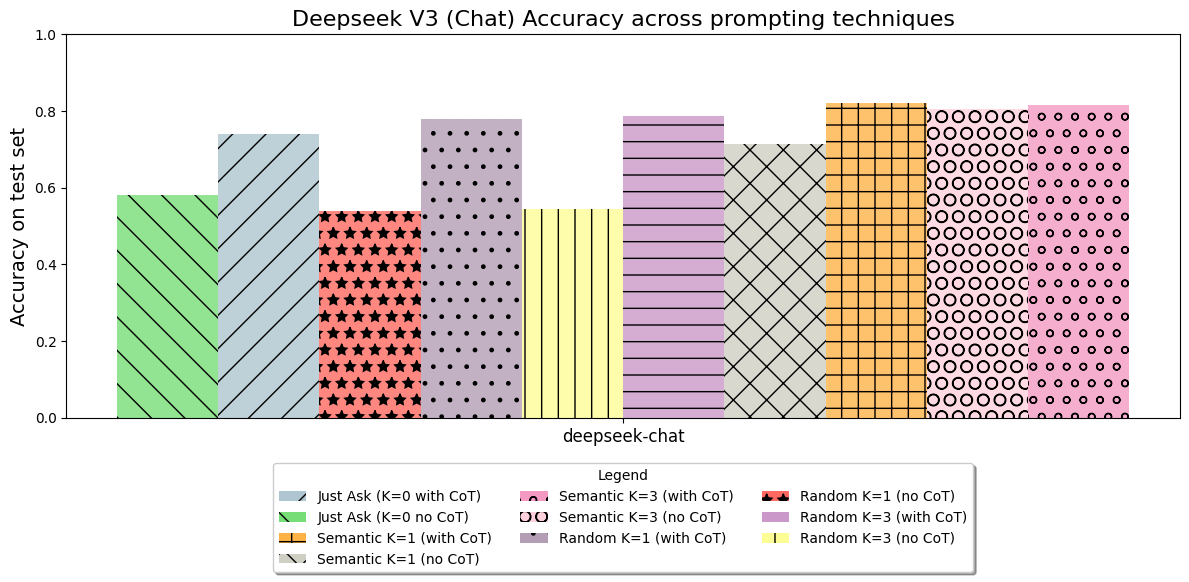

In [155]:
plot_results('Deepseek V3 (Chat) Accuracy across prompting techniques', filter_labels=['deepseek-chat'])